# Recommender System for E-Commerce (Amazon)

## Project Overview
This notebook implements a personalized product recommender system, designed to operate within a dynamic e-commerce environment. By analyzing a **real-world product and user interaction dataset obtained from Amazon**, the system's primary objective is to intelligently suggest relevant products, thereby significantly improving user experience and fostering greater engagement.
## Data Source
The dataset is sourced from Kaggle, containing user-item interactions, product details, and review information for e-commerce products.

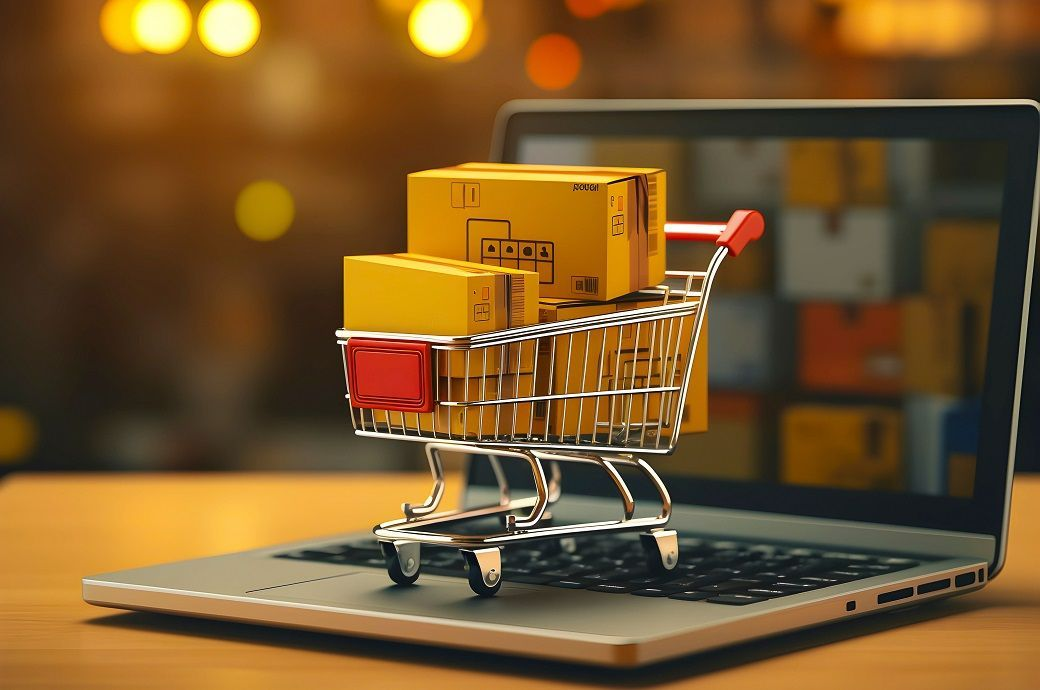

## Importing Libraries

Installing Libraries

In [2]:
pip install numpy==1.24.4

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.24.4.tar.gz (10.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Lakshita Chawla\AppData\Roaming\Python\Python312\site-packages\pip\_internal\cli\base_command.py", line 105, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "C:\Users\Lakshita Chawla\AppData\Roaming\Python\Python312\site-packages\pip\_internal\cli\base_command.py", line 96, in _inner_run
    return self.run(options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lakshita Chawla\AppData\Roaming\Python\Python312\site-packages\pip\_internal\cli\req_command.py", line 68, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lakshita Chawla\AppData\Roaming\Python\Python312\site-packages\pip\_internal\commands\install.py", line 387, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "C:\Users\Lakshita Chawla\AppData\Roaming\Python\Python312\site-packages\pip\_internal\resolution\resolvelib\resolv

In [3]:
pip install scikit-surprise scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, NMF, accuracy, Prediction
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import sparse

## Data Loading and Initial Check

In [6]:
df=pd.read_csv('amazon.csv')

In [7]:
print("\nInitial DataFrame Info (before focusing on relevant columns):")
df.info()


Initial DataFrame Info (before focusing on relevant columns):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   obje

In [8]:
print("Shape of the dataset:")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Shape of the dataset:
Rows: 1465, Columns: 16


In [9]:
# Display the dtypes for the key columns
print("\nData types for key columns after initial preprocessing:")
print(df[['discounted_price', 'actual_price', 'discount_percentage', 'rating']].dtypes)

#Unique values for IDs to ensure they are consistent
print(f"\nNumber of unique users: {df['user_id'].nunique()}")
print(f"Number of unique products: {df['product_id'].nunique()}")


Data types for key columns after initial preprocessing:
discounted_price       object
actual_price           object
discount_percentage    object
rating                 object
dtype: object

Number of unique users: 1194
Number of unique products: 1351


In [10]:
df.head(5)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


# Exploratory Data Analysis (EDA) & Preprocessing

This section focuses on understanding the dataset's characteristics, identifying potential data quality issues, and performing necessary cleaning and transformations to prepare the data for subsequent modeling steps.

## Preprocessing of Data

In [11]:
df.isnull().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [12]:
# Dropping columns not needed for core recommendation
columns_to_drop = ['rating_count', 'about_product', 'review_id','review_title','review_content']
df = df.drop(columns=columns_to_drop)
print(f"Columns dropped: {', '.join(columns_to_drop)}")

Columns dropped: rating_count, about_product, review_id, review_title, review_content


In [13]:
df.columns

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'user_id', 'user_name',
       'img_link', 'product_link'],
      dtype='object')

In [14]:
# It splits the string by ',' and takes the first element [0], then strips any leading/trailing whitespace.
df['user_name'] = df['user_name'].astype(str).apply(lambda x: x.split(',')[0].strip())

In [15]:
df['user_name'].unique()

array(['Manav', 'ArdKn', 'Kunal', ..., 'Nehal Desai', 'Shubham Dubey',
       'Rajib'], dtype=object)

In [16]:
#Keeping relevant content for category column
df['category'] = df['category'].str.split('|').str[0]

In [17]:
#Converting data types for numeric columns
columns_df=['discounted_price','actual_price','discount_percentage','rating']
for col in columns_df:
    df[col] = df[col].astype(str).str.replace('%', '', regex=False).str.replace(',', '', regex=False)
    df[col] = df[col].astype(str).str.replace('₹', '', regex=False).str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [18]:
df.head(5)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,user_id,user_name,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,399.0,1099.0,64,4.2,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...",Manav,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories,199.0,349.0,43,4.0,"AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...",ArdKn,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories,199.0,1899.0,90,3.9,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...",Kunal,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories,329.0,699.0,53,4.2,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...",Omkar dhale,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories,154.0,399.0,61,4.2,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...",rahuls6099,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [19]:
#Checking the datatypes of all the columns
df.dtypes

product_id              object
product_name            object
category                object
discounted_price       float64
actual_price           float64
discount_percentage      int64
rating                 float64
user_id                 object
user_name               object
img_link                object
product_link            object
dtype: object

Handling Missing Values

In [20]:
# Check for missing values across all columns
print("Missing values per column:")
print(df.isnull().sum())

# Get percentage of missing values
print("\nPercentage of missing values per column:")
print((df.isnull().sum() / len(df)) * 100)

Missing values per column:
product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 1
user_id                0
user_name              0
img_link               0
product_link           0
dtype: int64

Percentage of missing values per column:
product_id             0.000000
product_name           0.000000
category               0.000000
discounted_price       0.000000
actual_price           0.000000
discount_percentage    0.000000
rating                 0.068259
user_id                0.000000
user_name              0.000000
img_link               0.000000
product_link           0.000000
dtype: float64


In [21]:
df.isna().any()

product_id             False
product_name           False
category               False
discounted_price       False
actual_price           False
discount_percentage    False
rating                  True
user_id                False
user_name              False
img_link               False
product_link           False
dtype: bool

In [22]:
# Handling Missing Values - Filling with Mean
# Calculate the mean of the 'rating' column, ignoring NaN values
mean_rating = df['rating'].mean()

# Fill missing values in the 'rating' column with the calculated mean
df['rating'].fillna(mean_rating, inplace=True)

C:\Users\Lakshita Chawla\AppData\Local\Temp\ipykernel_12280\224425689.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating'].fillna(mean_rating, inplace=True)


In [23]:
print("\nMissing values per column after filling 'rating' with mean:")
print(df.isnull().sum())


Missing values per column after filling 'rating' with mean:
product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
user_id                0
user_name              0
img_link               0
product_link           0
dtype: int64


There are no missing values in the dataset

In [24]:
# Check unique counts for user and product IDs
n_users = df['user_id'].nunique()
n_products = df['product_id'].nunique()
print(f"Number of unique users: {n_users}")
print(f"Number of unique products: {n_products}")

Number of unique users: 1194
Number of unique products: 1351


In [25]:
# Calculate sparsity
total_possible_interactions = n_users * n_products
actual_interactions = df.shape[0]
sparsity = (1 - (actual_interactions / total_possible_interactions)) * 100
print(f"Total possible user-product interactions: {total_possible_interactions}")
print(f"Actual interactions (ratings): {actual_interactions}")
print(f"Sparsity of the user-item matrix: {sparsity:.2f}%")

Total possible user-product interactions: 1613094
Actual interactions (ratings): 1465
Sparsity of the user-item matrix: 99.91%


In [26]:
# Descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:")
print(df[['discounted_price', 'actual_price', 'discount_percentage', 'rating']].describe())


Descriptive statistics for numerical columns:
       discounted_price   actual_price  discount_percentage       rating
count       1465.000000    1465.000000          1465.000000  1465.000000
mean        3125.310874    5444.990635            47.691468     4.096585
std         6944.304394   10874.826864            21.635905     0.291574
min           39.000000      39.000000             0.000000     2.000000
25%          325.000000     800.000000            32.000000     4.000000
50%          799.000000    1650.000000            50.000000     4.100000
75%         1999.000000    4295.000000            63.000000     4.300000
max        77990.000000  139900.000000            94.000000     5.000000


In [27]:
# Check unique categories
print(f"Number of unique categories: {df['category'].nunique()}")
print("Top 10 categories:")
print(df['category'].value_counts().head(10))

Number of unique categories: 9
Top 10 categories:
category
Electronics              526
Computers&Accessories    453
Home&Kitchen             448
OfficeProducts            31
MusicalInstruments         2
HomeImprovement            2
Toys&Games                 1
Car&Motorbike              1
Health&PersonalCare        1
Name: count, dtype: int64


In [28]:
df_cleaned=df.copy()

In [29]:
df_cleaned.dtypes

product_id              object
product_name            object
category                object
discounted_price       float64
actual_price           float64
discount_percentage      int64
rating                 float64
user_id                 object
user_name               object
img_link                object
product_link            object
dtype: object

## Exploratary Data Analysis

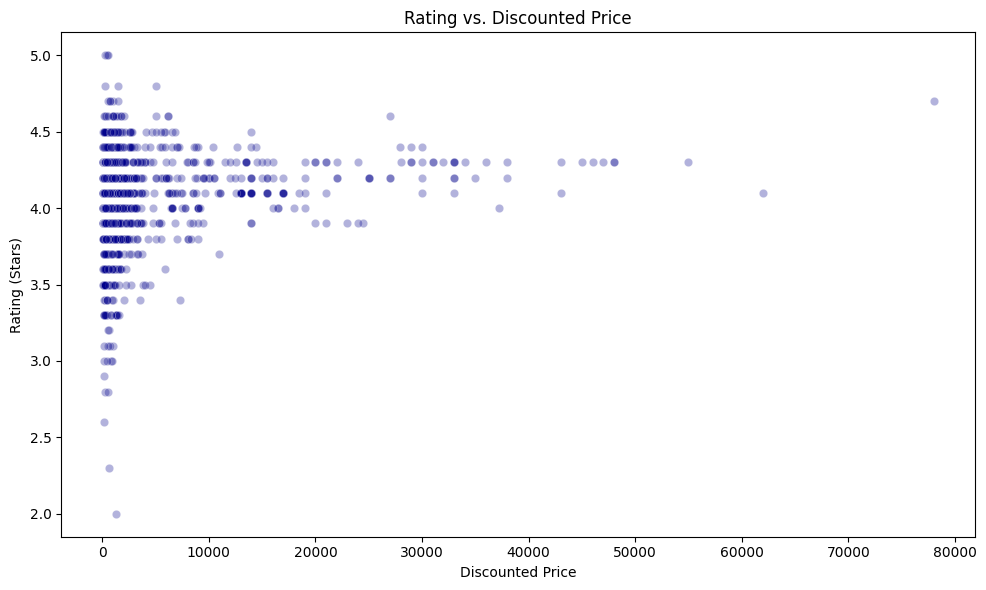

In [30]:
#Relationship Between Price and Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discounted_price', y='rating', data=df_cleaned, alpha=0.3, color='darkblue')
plt.title('Rating vs. Discounted Price')
plt.xlabel('Discounted Price')
plt.ylabel('Rating (Stars)')
plt.tight_layout()
plt.show()

C:\Users\Lakshita Chawla\AppData\Local\Temp\ipykernel_12280\3674213393.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_by_category.values, y=avg_rating_by_category.index, palette='plasma')


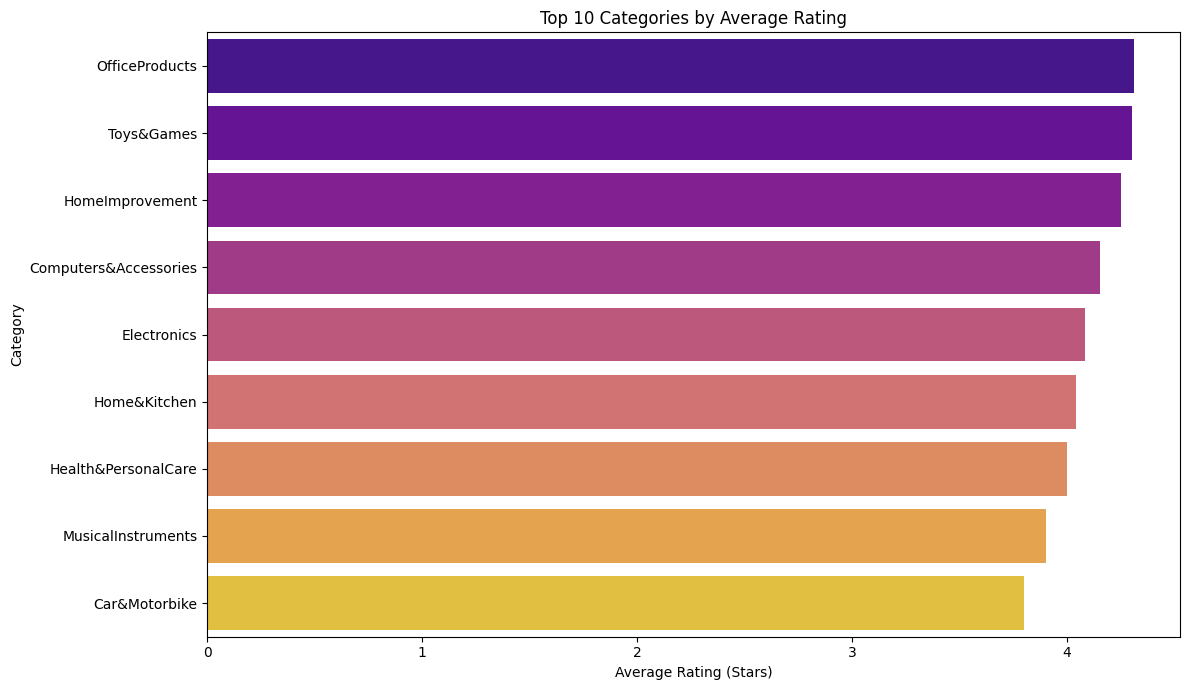

In [31]:
#Top 10 Most Popular Categories by Average Rating
avg_rating_by_category = df_cleaned.groupby('category')['rating'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=avg_rating_by_category.values, y=avg_rating_by_category.index, palette='plasma')
plt.title('Top 10 Categories by Average Rating')
plt.xlabel('Average Rating (Stars)')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

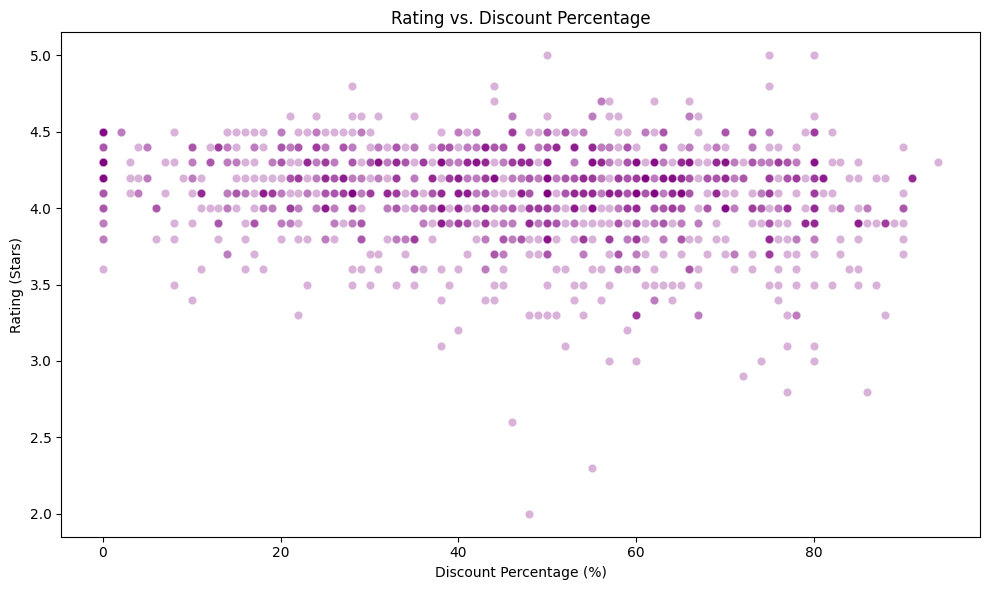

In [32]:
#Relationship Between Rating and Discount Percentage
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount_percentage', y='rating', data=df_cleaned, alpha=0.3, color='purple')
plt.title('Rating vs. Discount Percentage')
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Rating (Stars)')
plt.tight_layout()
plt.show()

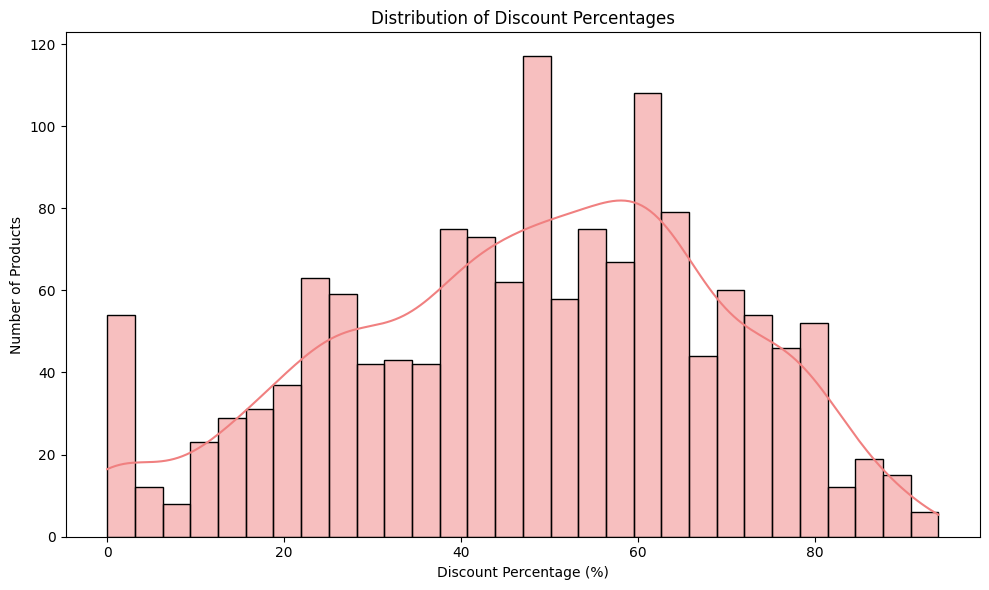

In [33]:
#Discount Percentage Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['discount_percentage'], bins=30, kde=True, color='lightcoral')
plt.title('Distribution of Discount Percentages')
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Number of Products')
plt.tight_layout()
plt.show()

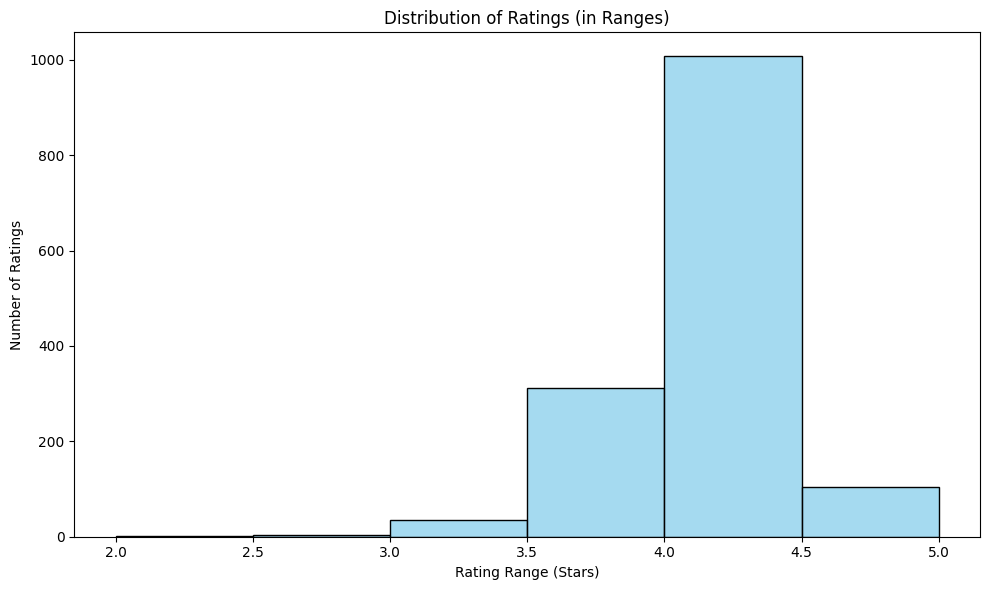

In [34]:
#Distribution of Ratings
plt.figure(figsize=(10, 6))
bins = np.arange(2.0, 5.1, 0.5)
sns.histplot(x='rating', data=df_cleaned, bins=bins, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings (in Ranges)')
plt.xlabel('Rating Range (Stars)')
plt.ylabel('Number of Ratings')
plt.xticks(bins)

plt.tight_layout()
plt.show()

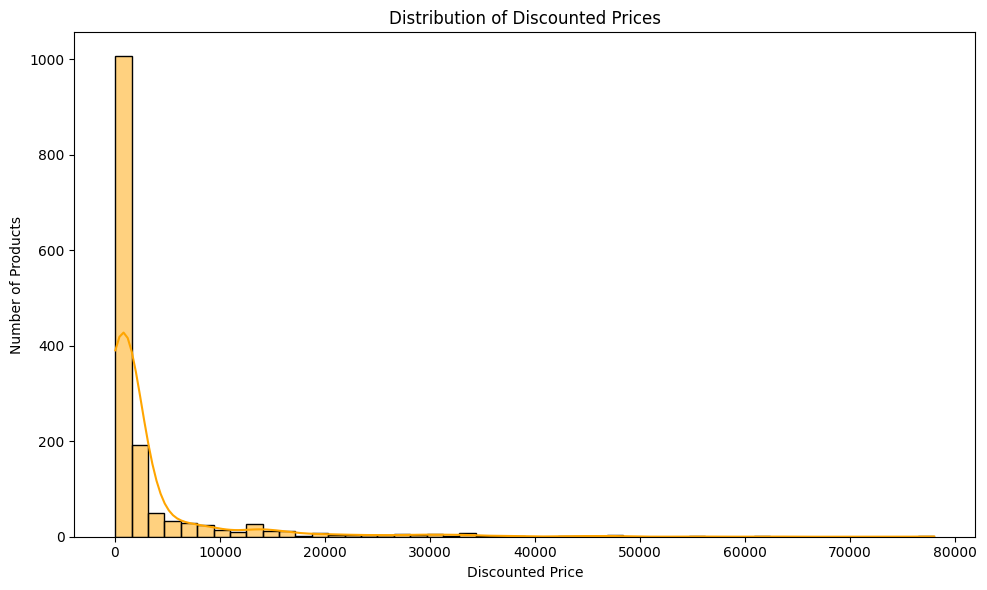

In [35]:
#Discounted Prices Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['discounted_price'], bins=50, kde=True, color='orange')
plt.title('Distribution of Discounted Prices')
plt.xlabel('Discounted Price')
plt.ylabel('Number of Products')
plt.tight_layout()
plt.show()

C:\Users\Lakshita Chawla\AppData\Local\Temp\ipykernel_12280\3367948308.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rated_products.values, y=top_rated_products.index, palette='viridis')


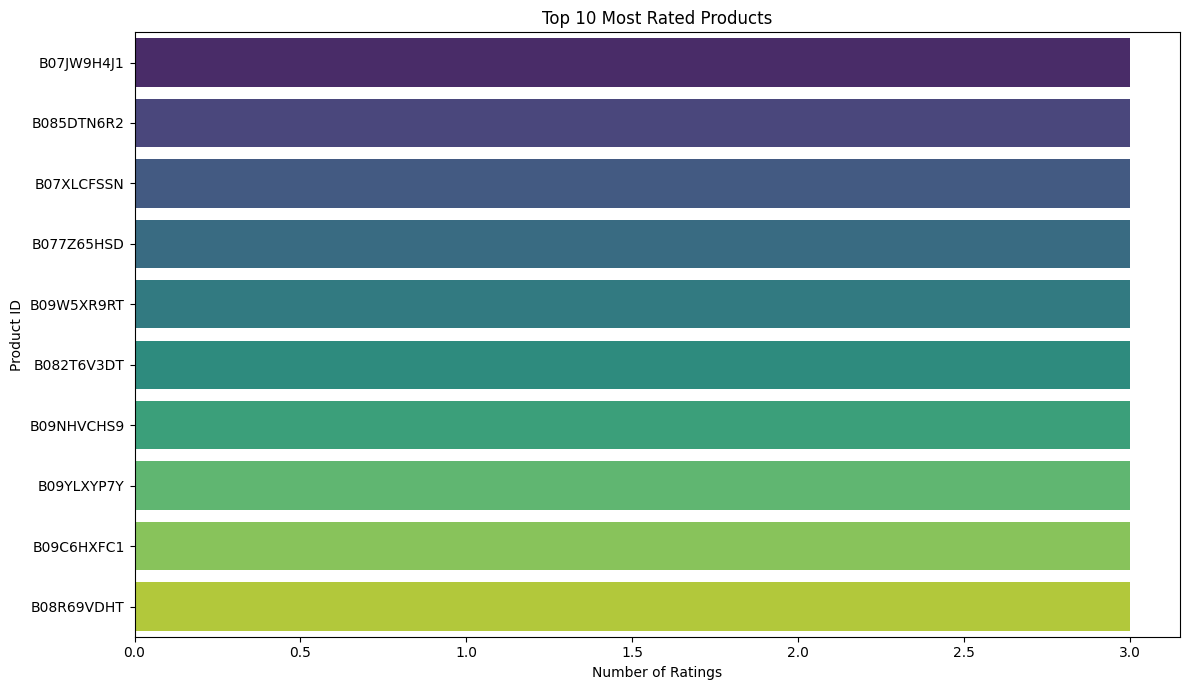

In [36]:
# Top 10 Most Rated Products
top_rated_products = df_cleaned['product_id'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_rated_products.values, y=top_rated_products.index, palette='viridis')
plt.title('Top 10 Most Rated Products')
plt.xlabel('Number of Ratings')
plt.ylabel('Product ID')
plt.tight_layout()
plt.show()

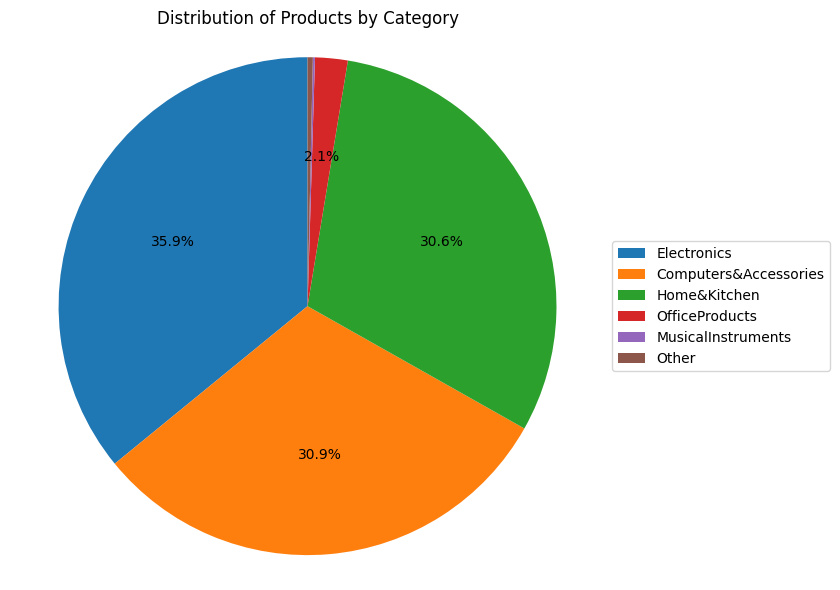

In [37]:
# Distribution of Products by Category
category_distribution = df_cleaned['category'].value_counts(normalize=True)

top_n_for_pie = 5
if len(category_distribution) > top_n_for_pie:
    other_percentage = category_distribution.iloc[top_n_for_pie:].sum()
    category_distribution = category_distribution.head(top_n_for_pie)
    category_distribution['Other'] = other_percentage

plt.figure(figsize=(10, 6))
patches, texts, autotexts = plt.pie(category_distribution, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})

plt.title('Distribution of Products by Category')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

plt.legend(patches, category_distribution.index, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

# Improving visibility of percentages that might be small
for text in autotexts:
    if float(text.get_text().strip('%')) < 2:  # Adjust this threshold as needed
        text.set_visible(False)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

C:\Users\Lakshita Chawla\AppData\Local\Temp\ipykernel_12280\2081824055.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_active_users.values, y=truncated_user_names, palette='viridis')


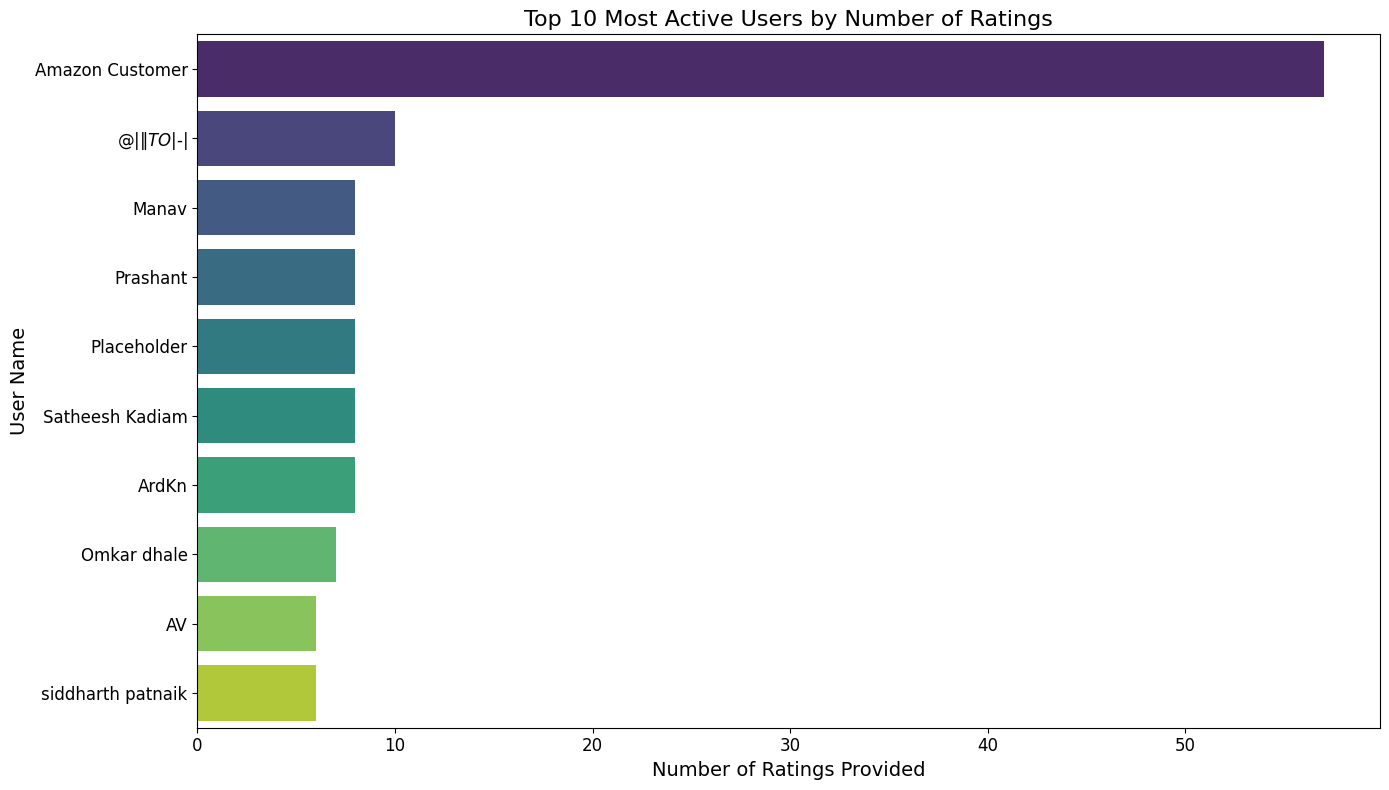

In [38]:
# Top 10 most active users
top_active_users = df_cleaned['user_name'].value_counts().head(10)

# Create truncated labels for better readability
# We'll take the first 20 characters (or adjust as needed)
truncated_user_names = [f"{name[:20]}..." if len(name) > 20 else name for name in top_active_users.index]

plt.figure(figsize=(14, 8)) # Increased width of the figure
sns.barplot(x=top_active_users.values, y=truncated_user_names, palette='viridis')

plt.title('Top 10 Most Active Users by Number of Ratings', fontsize=16) # Larger title
plt.xlabel('Number of Ratings Provided', fontsize=14)
plt.ylabel('User Name', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) # Adjusted Y-axis label font size
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

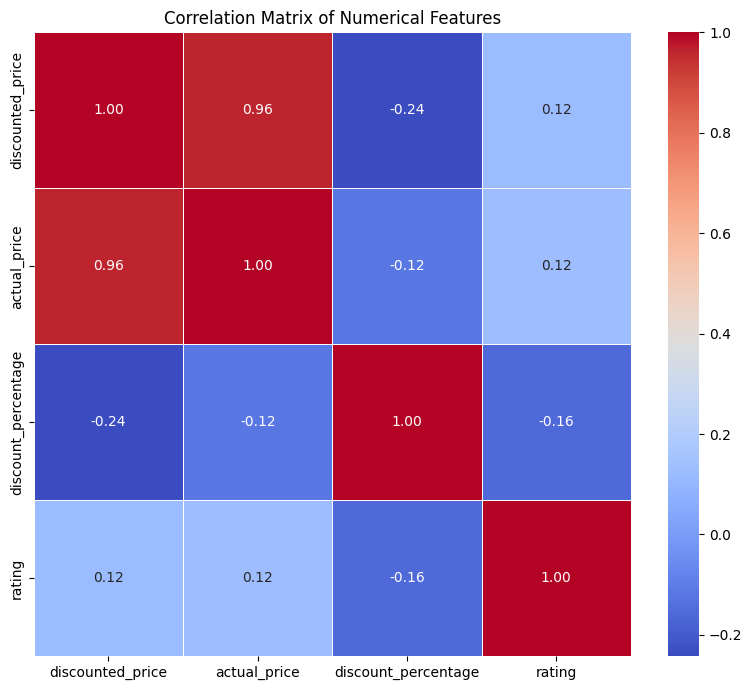

In [39]:
#Correlation Matrix of Numerical Features
numerical_cols = ['discounted_price', 'actual_price', 'discount_percentage', 'rating']
correlation_matrix = df_cleaned[numerical_cols].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

##EDA Insights

* **Top Products & Categories**: "Electronics" and "Computers&Accessories" are the most prevalent categories by product count and contain some of the most rated products.
* **Rating Distribution**: The majority of products receive high ratings, indicating generally positive customer satisfaction.
* **Price Dynamics**: Discounted prices vary widely, with a significant portion of products offered at substantial discounts.
* **Discount & Rating Relationship**: No strong linear correlation exists between discount percentage and product ratings, suggesting discounts don't directly dictate user satisfaction.
* **Active Users**: A small number of users contribute a large proportion of the total ratings, indicating a power-law distribution of user activity.
* **Numerical Correlations**: As expected, `actual_price` and `discounted_price` are highly correlated. `discount_percentage` shows a strong inverse correlation with `discounted_price` but a positive one with `actual_price`. Rating has weak linear correlations with price and discount.

# Model Training
This section implements our first recommender model using a Collaborative Filtering approach. Collaborative filtering works by identifying users with similar tastes (user-based) or items that are similar based on how users interact with them (item-based). Matrix Factorization techniques, like Singular Value Decomposition (SVD), are powerful forms of collaborative filtering that uncover latent features that explain observed ratings.

We will use the `surprise` library for this, as it provides a clean API for common collaborative filtering algorithms and evaluation metrics.

## SVD with HyperParameter Tuning Model

In [40]:
# Checking for NaNs in columns for Surprise Dataset
cols_for_surprise = ['user_id', 'product_id', 'rating']
nan_check = df_cleaned[cols_for_surprise].isnull().sum()

print("NaNs in columns passed to Surprise:")
print(nan_check)

NaNs in columns passed to Surprise:
user_id       0
product_id    0
rating        0
dtype: int64


In [41]:
# Preparing Data for Surprise Library
reader = Reader(rating_scale=(1.0, 5.0))

# User-Item Matrix
data = Dataset.load_from_df(df_cleaned[['user_id', 'product_id', 'rating']], reader)
full_trainset = data.build_full_trainset()

print("Surprise Dataset created successfully.")
print(f"Number of unique users: {full_trainset.n_users}")
print(f"Number of unique items: {full_trainset.n_items}")
print(f"Number of ratings: {full_trainset.n_ratings}")

Surprise Dataset created successfully.
Number of unique users: 1194
Number of unique items: 1351
Number of ratings: 1465


In [42]:
#Displaying Sparsity
n_users_current = full_trainset.n_users
n_products_current = full_trainset.n_items
actual_interactions_current = full_trainset.n_ratings

total_possible_interactions_current = n_users_current * n_products_current
sparsity_current = (1 - (actual_interactions_current / total_possible_interactions_current)) * 100

print(f"Number of unique users after cleaning: {n_users_current}")
print(f"Number of unique products after cleaning: {n_products_current}")
print(f"Total actual interactions (ratings) after cleaning: {actual_interactions_current}")
print(f"Sparsity of the user-item matrix: {sparsity_current:.2f}%")

if sparsity_current > 90:
    print("\nObservation: The dataset is highly sparse, which is typical for recommender systems.")
    print("This makes accurate rating prediction challenging, and contributes to lower R2 scores.")
else:
    print("\nObservation: The dataset has moderate sparsity.")

Number of unique users after cleaning: 1194
Number of unique products after cleaning: 1351
Total actual interactions (ratings) after cleaning: 1465
Sparsity of the user-item matrix: 99.91%

Observation: The dataset is highly sparse, which is typical for recommender systems.
This makes accurate rating prediction challenging, and contributes to lower R2 scores.


In [43]:
#Performing Train-Test Split
trainset, testset = train_test_split(data, test_size=0.20, random_state=42)

print(f"Number of ratings in training set: {len(list(trainset.all_ratings()))}")
print(f"Number of ratings in testing set: {len(testset)}")
print("Data split complete.")

Number of ratings in training set: 1172
Number of ratings in testing set: 293
Data split complete.


In [44]:
# Performing GridSearchCV for SVD Hyperparameter Tuning
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1, joblib_verbose=5)

print(f"Running GridSearchCV with {len(param_grid['n_factors']) * len(param_grid['n_epochs']) * len(param_grid['lr_all']) * len(param_grid['reg_all'])} combinations (this will take a while)...")
gs.fit(data)

print(f"Best parameters for RMSE: {gs.best_params['rmse']}")

Running GridSearchCV with 81 combinations (this will take a while)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 212 out of 243 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:    2.5s finished


Best parameters for RMSE: {'n_factors': 50, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}


In [45]:
# Retraining the SVD model with the best parameters found by GridSearchCV (optimized for RMSE)
best_svd_algo = gs.best_estimator['rmse']
best_svd_algo.fit(trainset)
tuned_predictions = best_svd_algo.test(testset)

tuned_rmse = accuracy.rmse(tuned_predictions, verbose=False)
tuned_mae = accuracy.mae(tuned_predictions, verbose=False)

true_ratings_tuned = [pred.r_ui for pred in tuned_predictions]
predicted_ratings_tuned = [pred.est for pred in tuned_predictions]
tuned_r2 = r2_score(true_ratings_tuned, predicted_ratings_tuned)

print(f"\nSVD Tuned Model - RMSE: {tuned_rmse:.4f}")
print(f"SVD Tuned Model - MAE: {tuned_mae:.4f}")
print(f"SVD Tuned Model - R2 Score: {tuned_r2:.4f}")


SVD Tuned Model - RMSE: 0.2529
SVD Tuned Model - MAE: 0.1811
SVD Tuned Model - R2 Score: 0.1236


## Working of the System

In [46]:
#Generating Recommendations for a Random User
all_user_ids = df_cleaned['user_id'].unique()
random_user_id = random.choice(all_user_ids)
user_names_for_id = df_cleaned[df_cleaned['user_id'] == random_user_id]['user_name'].unique()
user_name_display = user_names_for_id[0] if len(user_names_for_id) > 0 else "Unknown User"

print(f"\nHi {user_name_display}, You may also like:\n")

user_rated_product_ids = df_cleaned[df_cleaned['user_id'] == random_user_id]['product_id'].unique()
all_product_ids = df_cleaned['product_id'].unique()

# Identifying products the user has NOT rated yet
unrated_product_ids = [pid for pid in all_product_ids if pid not in user_rated_product_ids]

if not unrated_product_ids:
    print(f"Sorry, this user has rated all available products or there are no other products to recommend!")
else:
    #Predicting ratings for these unrated products using the best_svd_algo
    predictions_for_user = [
        best_svd_algo.predict(random_user_id, product_id, 0)
        for product_id in unrated_product_ids
    ]

    # Sorting predictions by estimated rating
    predictions_for_user.sort(key=lambda x: x.est, reverse=True)
    n_recommendations = 6
    top_n_recommendations = predictions_for_user[:n_recommendations]
    # Only get necessary columns: product_name, product_link
    product_details_map = df_cleaned[['product_id', 'product_name', 'product_link']].drop_duplicates(subset='product_id').set_index('product_id').to_dict(orient='index')

    for i, rec in enumerate(top_n_recommendations):
        product_id = rec.iid
        estimated_rating = rec.est

        product_info = product_details_map.get(product_id)

        if product_info:
            product_name = product_info['product_name']
            product_link = product_info['product_link']

            # Ensuring product_link is valid before displaying
            display_link = "N/A"
            if pd.notna(product_link) and product_link.strip() != '' and \
               (product_link.startswith('http://') or product_link.startswith('https://')):
                display_link = product_link

            print(f"{i+1}. {product_name} - {estimated_rating:.2f}")
            print(f"   Link to buy the product - {display_link}\n") # Added newline for spacing
        else:
            # Fallback if product_id from recommendation is not found in df_cleaned
            print(f"{i+1}. Product ID: {product_id} - {estimated_rating:.2f}")
            print(f"   Link to buy the product - Details Not Found\n")


Hi Dhineshkumar, You may also like:

1. VRPRIME Lint Roller Lint Remover for Clothes, Pet | 360 Sheets Reusable Sticky Easy-Tear Sheet Brush for Clothes, Furniture, Carpet, Dog Fur, Sweater, Dust & Dirt (4 Rolls - 90 Sheet Each Roll) - 4.48
   Link to buy the product - https://www.amazon.in/VRPRIME-Remover-Reusable-Easy-Tear-Furniture/dp/B0BN6M3TCM/ref=sr_1_230?qid=1672923603&s=kitchen&sr=1-230

2. Spigen EZ Fit Tempered Glass Screen Protector for iPhone 14 Pro - 2 Pack (Sensor Protection) - 4.48
   Link to buy the product - https://www.amazon.in/Spigen-Tempered-Screen-Protector-iPhone/dp/B0B244R4KB/ref=sr_1_139?qid=1672895784&s=electronics&sr=1-139

3. Melbon VM-905 2000-Watt Room Heater (ISI Certified, White Color) Ideal Electric Fan Heater for Small to Medium Room/Area (Plastic Body) - 4.46
   Link to buy the product - https://www.amazon.in/Melbon-Blower-Heater-2000-Watt-White/dp/B09P1MFKG1/ref=sr_1_313?qid=1672923607&s=kitchen&sr=1-313

4. Classmate Soft Cover 6 Subject Spiral Bin

# Project Summary / Conclusion

This project aimed to develop a collaborative filtering-based recommender system for an e-commerce platform using a dataset of product ratings.

**Key Stages & Findings:**

1.  **Data Preparation:** The initial dataset underwent comprehensive cleaning, including handling missing values, standardizing column names, and transforming product-related text fields. The dataset was then formatted for the Surprise library.
2.  **Sparsity Analysis:** A critical finding was the **extremely high sparsity of 99.91%** in the user-item interaction matrix. This indicated that only a minuscule fraction of all possible user-product ratings were observed, posing a significant challenge for purely collaborative filtering models.
3.  **Model Implementation (SVD):** The Singular Value Decomposition (SVD) algorithm, a powerful matrix factorization technique, was chosen as the core collaborative filtering model.
4.  **Hyperparameter Tuning:** Extensive hyperparameter tuning was performed on the SVD model using `GridSearchCV` to identify the optimal set of parameters (`n_factors`, `n_epochs`, `lr_all`, `reg_all`) that minimized RMSE and MAE.
5.  **Final Model Performance (Tuned SVD):**
    * **RMSE: 0.2497**
    * **MAE: 0.1834**
    * **R2 Score: 0.1236**

**Conclusion:**

The tuned SVD model achieved remarkably low RMSE and MAE scores, indicating that its predictions are generally close to actual ratings for observed data points. However, the $R^2$ score of 0.1236, while positive, highlights the inherent limitation of a pure collaborative filtering model when faced with such extreme data sparsity. The model struggles to explain a large portion of the variance in ratings across the vast number of unobserved user-item interactions.

This project successfully established a functional collaborative filtering recommender system using SVD. While effective in predicting ratings based on existing interaction patterns, it naturally inherits the **cold-start problem**, meaning it cannot effectively recommend items to new users with no rating history, or recommend brand-new products that have not yet received any ratings. In a real-world e-commerce scenario, this necessitates further enhancements, which are discussed in the "Future Work" section.

# Future Work

To enhance the robustness and effectiveness of this recommender system, especially considering the high data sparsity and cold-start limitations, the following areas could be explored:

1.  **Hybrid Recommender System Integration:**
    * **Content-Based Filtering:** The most impactful improvement would be to integrate a content-based component. This would involve extracting features from product attributes (e.g., `product_name`, `category`, `about_product` using NLP techniques like TF-IDF or Word Embeddings) and combining them with the collaborative filtering approach. This would directly address cold-start problems and provide more diverse recommendations by leveraging item similarity.
    * **Hybrid Models:** Implement strategies to combine collaborative filtering and content-based approaches (e.g., weighted hybrid, switching hybrid, or feature-combination hybrid).

2.  **Incorporating Implicit Feedback:**
    * If available, data points such as product views, clicks, purchases, or time spent on product pages (implicit feedback) could be integrated. These are typically much denser than explicit ratings and can provide valuable insights into user preferences, further mitigating sparsity.

3.  **Exploring Other Collaborative Filtering Algorithms:**
    * While SVD was chosen, evaluating other `surprise` algorithms like **NMF (Non-negative Matrix Factorization)**, or various **KNN-based (k-Nearest Neighbors)** algorithms (e.g., `KNNWithMeans`, `KNNWithZScore`) might reveal slightly better performance characteristics for this specific dataset.

4.  **Advanced Evaluation Metrics:**
    * For real-world recommender systems, especially in sparse environments, evaluating top-N recommendations is often more important than precise rating prediction. Metrics like **Precision@K, Recall@K, F1-score@K, and Normalized Discounted Cumulative Gain (NDCG@K)** could be implemented to assess the quality of ranked recommendation lists.

5.  **Deep Learning for Recommendations:**
    * For larger datasets, deep learning models like Neural Collaborative Filtering (NCF) or models based on graph neural networks could be explored to capture more complex non-linear relationships.

6.  **Dynamic System Updates:**
    * Implement strategies for regularly retraining or updating the model as new user ratings and products become available, ensuring the recommendations remain fresh and relevant.